ERROR: Could not find a version that satisfies the requirement msttcorefonts (from versions: none)
ERROR: No matching distribution found for msttcorefonts


In [22]:
! rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
df = pd.read_csv('data.csv',encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])
# keep only the most recent date of purchase
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min')
df_rec = df[df['rank']==1]

In [3]:
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


/tmp/ipykernel_34/55442679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


In [4]:
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']
rec_freq = df_freq.merge(df_rec,on='CustomerID')

In [7]:
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']

In [8]:
rfm = m.merge(rec_freq,on='CustomerID')
finaldf = rfm[['CustomerID','recency','frequency','monetary_value']]

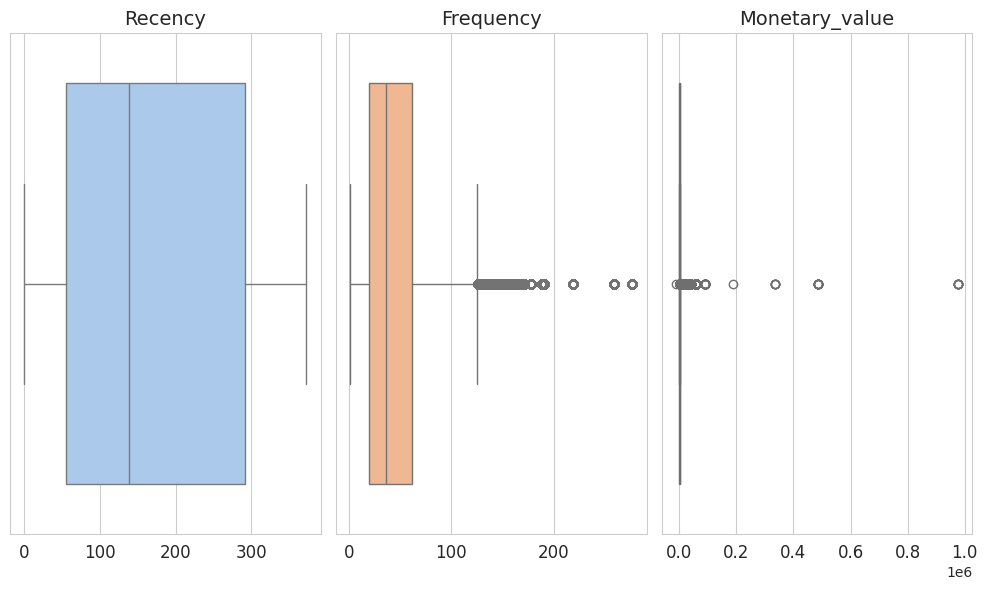

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Customizing style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Data
list1 = ['recency', 'frequency', 'monetary_value']

# Custom color palette
colors = sns.color_palette("pastel")

# # Custom font
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Helvetica'

# Plotting
for i, variable in enumerate(list1, start=1):
    plt.subplot(1, 3, i)
    ax = sns.boxplot(x=finaldf[variable], color=colors[i - 1])
    plt.title(variable.capitalize(), fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


In [10]:
from scipy import stats
import numpy as np
# remove the customer id column
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]
new_df.head()

,recency,frequency,monetary_value
1,6,31,1246.73
2,6,31,1246.73
3,6,31,1246.73
4,6,31,1246.73
5,6,31,1246.73


In [11]:
from sklearn.preprocessing import StandardScaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,recency,frequency,monetary_value
0,-1.196723,0.379971,0.185080
1,-1.120665,-0.259085,1.965919
2,1.752654,2.297138,0.401256
3,-0.715020,-0.259085,-0.217826
4,-0.596706,-0.350378,0.011294


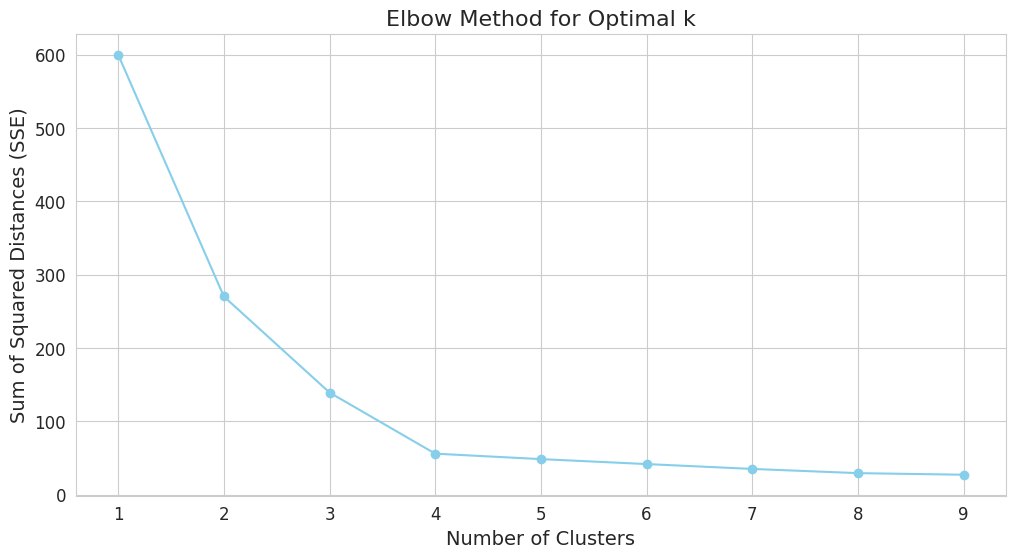

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Generate sample data (you need to replace this with your data)
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Example scaling of features
# You should replace this with your own scaling code if necessary
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

SSE = []
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster': range(1, 10), 'SSE': SSE})

# Customizing style
plt.figure(figsize=(12, 6))

# Plotting
plt.plot(frame['Cluster'], frame['SSE'], marker='o', color='skyblue', linestyle='-')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Sum of Squared Distances (SSE)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.show()


In [13]:
# First, build a model with 4 clusters
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=4)

In [14]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))


0.43600059110868045


In [15]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

/tmp/ipykernel_34/2687900227.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x='cluster', y=variable, data=avg_df, palette=colors, hue = 'cluster')
/tmp/ipykernel_34/2687900227.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x='cluster', y=variable, data=avg_df, palette=colors, hue = 'cluster')
/tmp/ipykernel_34/2687900227.py:20: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x='cluster', y=variable, data=avg_df, palette=colors, hue = 'cluster')


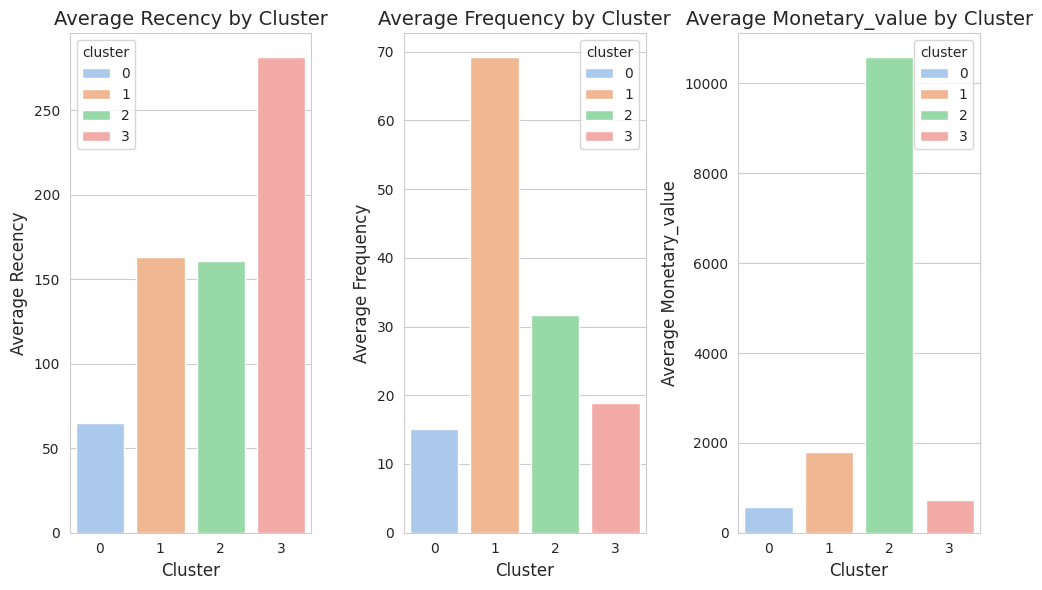

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have avg_df computed

# Customizing style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Custom color palette
colors = sns.color_palette("pastel")

# # Custom font
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Arial'

# Plotting
for i, variable in enumerate(list1, start=1):
    plt.subplot(1, len(list1), i)
    sns.barplot(x='cluster', y=variable, data=avg_df, palette=colors, hue = 'cluster')
    plt.title(f"Average {variable.capitalize()} by Cluster", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(f"Average {variable.capitalize()}", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f00183f9-5f53-4385-a647-c0cb231e91f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>